In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')
products = pd.read_csv('/content/Products.csv')

In [10]:
def calculate_rfm(transactions, analysis_date):
    # Convert to datetime
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

    # Calculate customer-level metrics
    rfm = transactions.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (analysis_date - x.max()).days,  # Recency
        'TransactionID': 'count',  # Frequency
        'TotalValue': 'sum'  # Monetary
    }).reset_index()

    # Rename columns
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    return rfm

In [12]:
def calculate_customer_metrics(transactions, customers, products):
    # Average order value
    customer_metrics = transactions.groupby('CustomerID').agg({
        'TotalValue': 'mean'
    }).reset_index()
    customer_metrics.columns = ['CustomerID', 'AvgOrderValue']

    # Unique products purchased
    unique_products = transactions.groupby('CustomerID')['ProductID'].nunique().reset_index()
    unique_products.columns = ['CustomerID', 'UniqueProducts']

    # Merge metrics
    customer_metrics = pd.merge(customer_metrics, unique_products, on='CustomerID')

    # Add customer region
    customer_metrics = pd.merge(customer_metrics, customers[['CustomerID', 'Region']], on='CustomerID')

    return customer_metrics

In [13]:
def perform_clustering(data, n_clusters):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)


    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette = silhouette_score(scaled_features, clusters)

    return clusters, db_index, silhouette, kmeans, scaled_features

In [14]:
analysis_date = pd.to_datetime(transactions['TransactionDate']).max()


rfm_data = calculate_rfm(transactions, analysis_date)

customer_metrics = calculate_customer_metrics(transactions, customers, products)

# Combine all features
final_features = pd.merge(rfm_data, customer_metrics, on='CustomerID')

features_for_clustering = final_features[['Recency', 'Frequency', 'Monetary',
                                       'AvgOrderValue', 'UniqueProducts']]

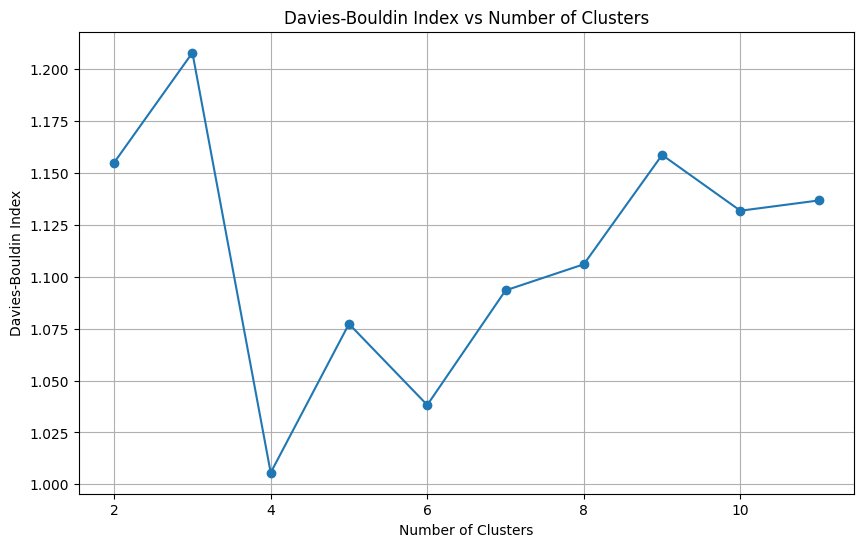

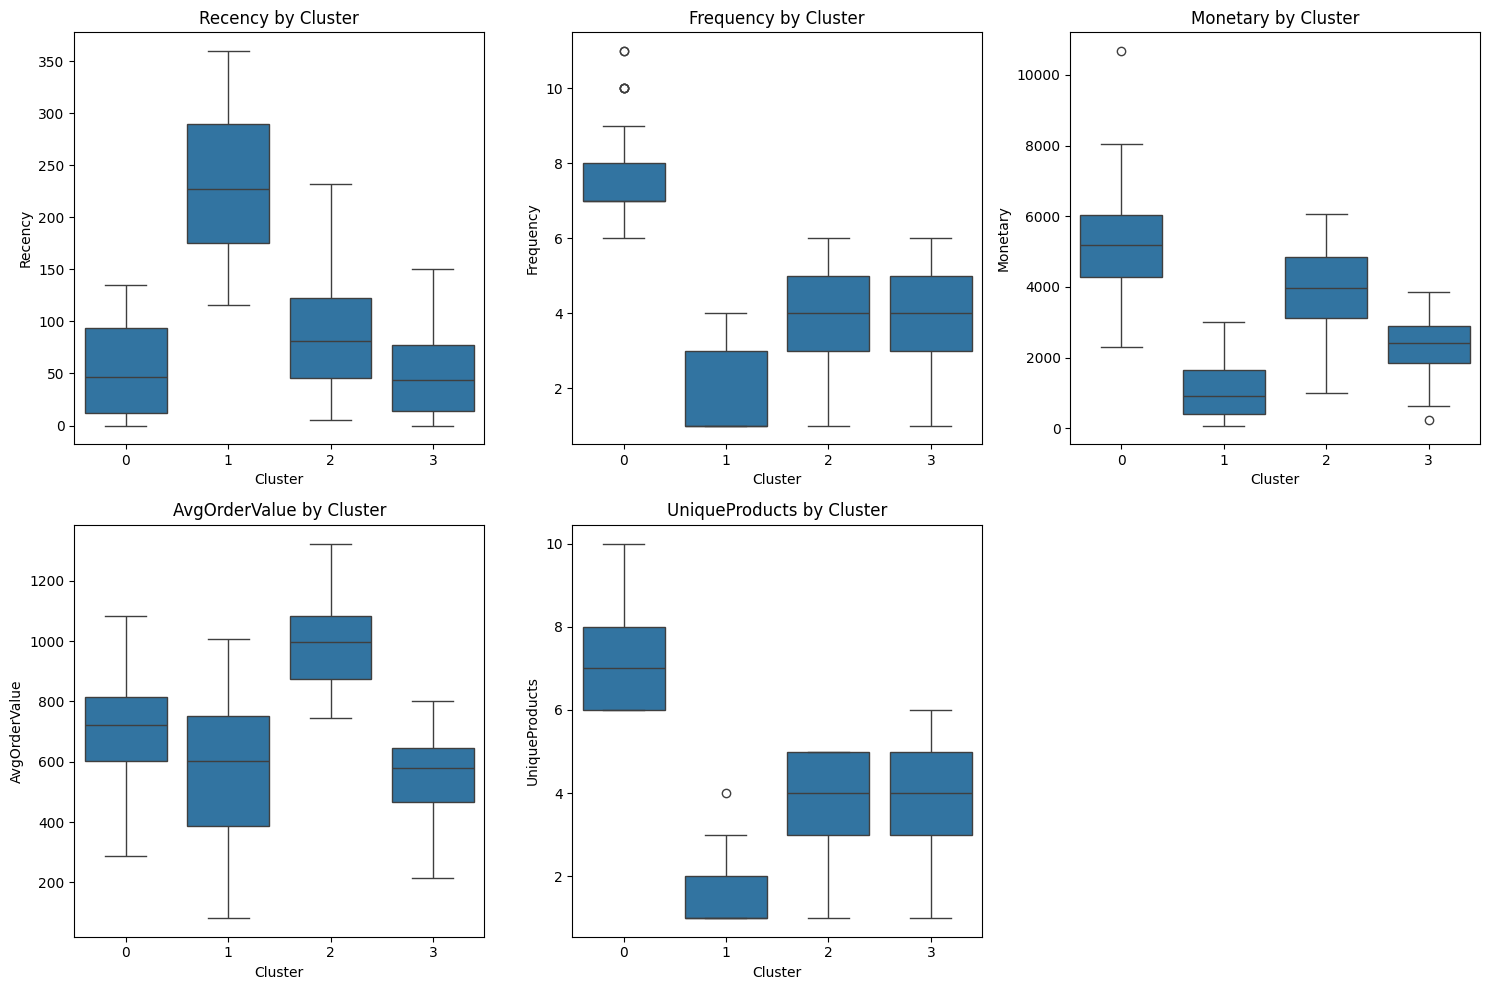


Clustering Results:
Optimal number of clusters: 4
Davies-Bouldin Index: 1.006
Silhouette Score: 0.323

Cluster Profiles:
         Recency  Frequency  Monetary  AvgOrderValue  UniqueProducts
Cluster                                                             
0          53.88       7.55   5249.29         702.06            7.28
1         243.82       1.76   1070.56         563.32            1.71
2          85.05       4.00   3952.47         997.34            3.90
3          48.03       4.19   2299.94         549.66            4.14


In [32]:

n_clusters_range = range(2,12)
db_scores = []
silhouette_scores = []

for n in n_clusters_range:
    clusters, db_index, silhouette, _, _ = perform_clustering(features_for_clustering, n)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette)


optimal_n_clusters = n_clusters_range[np.argmin(db_scores)]

clusters, final_db_index, final_silhouette, kmeans_model, scaled_data = perform_clustering(
    features_for_clustering, optimal_n_clusters)


final_features['Cluster'] = clusters


plt.figure(figsize=(10, 6))
plt.plot(list(n_clusters_range), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))
features_to_plot = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'UniqueProducts']
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=final_features)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()


print(f"\nClustering Results:")
print(f"Optimal number of clusters: {optimal_n_clusters}")
print(f"Davies-Bouldin Index: {final_db_index:.3f}")
print(f"Silhouette Score: {final_silhouette:.3f}")


cluster_profiles = final_features.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AvgOrderValue': 'mean',
    'UniqueProducts': 'mean'
}).round(2)

print("\nCluster Profiles:")
print(cluster_profiles)
